In [1]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pickle
from time import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from string import punctuation
from sklearn.model_selection import KFold

In [2]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [3]:
stop_words = set(stopwords.words('english')) 

In [4]:
trn = pd.read_csv('./train.csv')
trn

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from string import punctuation
from autocorrect import spell

snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

class TextPreprocess:
    def __int__(self):
        pass

    def autospell(self,text):
        """
        correct the spelling of the word.
        """
        spells = [spell(w) for w in (nltk.word_tokenize(text))]
        return " ".join(spells)

    def to_lower(self,text):
        """
        :param text:
        :return:
            Converted text to lower case as in, converting "Hello" to "hello" or "HELLO" to "hello".
        """
        return text.lower()

    def remove_numbers(self,text):
        """
        take string input and return a clean text without numbers.
        Use regex to discard the numbers.
        """
        output = ''.join(c for c in text if not c.isdigit())
        return output

    def remove_punct(self,text):
        """
        take string input and clean string without punctuations.
        use regex to remove the punctuations.
        """
        return ''.join(c for c in text if c not in punctuation)

    def remove_Tags(self,text):
        """
        take string input and clean string without tags.
        use regex to remove the html tags.
        """
        cleaned_text = re.sub('<[^<]+?>', '', text)
        return cleaned_text

    def sentence_tokenize(self,text):
        """
        take string input and return list of sentences.
        use nltk.sent_tokenize() to split the sentences.
        """
        sent_list = []
        for w in nltk.sent_tokenize(text):
            sent_list.append(w)
        return sent_list

    def word_tokenize(self,text):
        """
        :param text:
        :return: list of words
        """
        return [w for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)]

    def remove_stopwords(self,sentence):
        """
        removes all the stop words like "is,the,a, etc."
        """
        stop_words = stopwords.words('english')
        return ' '.join([w for w in nltk.word_tokenize(sentence) if not w in stop_words])

    def stem(self,text):
        """
        :param word_tokens:
        :return: list of words
        """
        stemmed_word = [snowball_stemmer.stem(word) for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
        return " ".join(stemmed_word)

    def lemmatize(self,text):
        lemmatized_word = [wordnet_lemmatizer.lemmatize(word)for sent in nltk.sent_tokenize(text)for word in nltk.word_tokenize(sent)]
        return " ".join(lemmatized_word)


    def preprocess(self,text):
        lower_text = self.to_lower(text)
        sentence_tokens = self.sentence_tokenize(lower_text)
        word_list = []
        for each_sent in sentence_tokens:
            lemmatizzed_sent = self.lemmatize(each_sent)
            clean_text = self.remove_numbers(lemmatizzed_sent)
            clean_text = self.remove_punct(clean_text)
            clean_text = self.remove_Tags(clean_text)
            clean_text = self.remove_stopwords(clean_text)
            word_tokens = self.word_tokenize(clean_text)
            for i in word_tokens:
                word_list.append(i)
        return " ".join(word_list).strip()

In [6]:
from nltk.stem import WordNetLemmatizer
def make_token(text) :
    text["text"] = text["text"].apply(lambda x : TextPreprocess().preprocess(x))
    return text    

In [8]:
from multiprocessing import  Pool
def parallelize_dataframe(df, func, n_cores=16):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
trn = parallelize_dataframe(trn, make_token)

KeyboardInterrupt: 

In [5]:
tst = pd.read_csv('./test_x.csv')

In [109]:
tst = parallelize_dataframe(tst, make_token)

# 여기부터

In [4]:
trn = pd.read_csv('eda_trn.csv', encoding = 'utf-8')
tst = pd.read_csv('./eda_tst.csv')

In [6]:

X_train = np.array([x for x in trn['text']])
Y_train = np.array([x for x in trn['author']])

X_test = np.array([x for x in tst['text']])

X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)


NameError: name 'train_test_split' is not defined

In [ ]:
X_train

In [15]:
max_len = max(len(i) for i in X_train)
print(max_len)

1450


In [7]:
#파라미터 설정
vocab_size = 25000
embedding_dim = 8
max_length = 1000
padding_type='post'
#oov_tok = "<OOV>"

#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [8]:
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
add_attention = True

In [9]:
with tf.device('/gpu:0'):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length), Dropout(0.5),
        *([LSTM(10, return_sequences=True), Attention()] if add_attention
          else [LSTM(100), Dense(350, activation='relu')]),
    #     tf.keras.layers.GlobalAveragePooling1D(),
        Dense(5, activation='softmax')
    ])

In [17]:
model.load_weights('my_model_weights.h5')

In [10]:
# import keras
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 8)           200000    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 8)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 10)          760       
_________________________________________________________________
attention_score_vec (Dense)  (None, 1000, 10)          100       
_________________________________________________________________
last_hidden_state (Lambda)   (None, 10)                0         
_________________________________________________________________
attention_score (Dot)        (None, 1000)              0         
_________________________________________________________________
attention_weight (Activation (None, 1000)              0

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)

In [12]:
kf = KFold(5, True)

/Users/woolarinet/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass shuffle=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:
Y_train

array([3, 2, 1, ..., 1, 3, 0])

In [16]:
acc_per_fold = []
loss_per_fold = []
models = []
train_index, test_index = next(iter( kf.split(train_padded)))
num_epochs = 100
history = model.fit(train_padded[train_index], Y_train[train_index], 
                    epochs=num_epochs,callbacks = [es, mc], verbose=1, 
                    validation_split=0.2,batch_size=16)
scores = model.evaluate(train_padded[test_index], Y_train[test_index])
print(scores)
acc_per_fold.append(scores[1])
loss_per_fold.append(scores[0])

Epoch 1/100
2196/2196 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.7633
Epoch 00001: val_accuracy improved from 0.72862 to 0.73078, saving model to best_model.h5
2196/2196 [==============================] - 644s 293ms/step - loss: 0.6272 - accuracy: 0.7633 - val_loss: 0.7234 - val_accuracy: 0.7308
Epoch 2/100
2196/2196 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7781
Epoch 00002: val_accuracy improved from 0.73078 to 0.73875, saving model to best_model.h5
2196/2196 [==============================] - 668s 304ms/step - loss: 0.5908 - accuracy: 0.7781 - val_loss: 0.7062 - val_accuracy: 0.7388
Epoch 3/100
2196/2196 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7858
Epoch 00003: val_accuracy did not improve from 0.73875
2196/2196 [==============================] - 854s 389ms/step - loss: 0.5668 - accuracy: 0.7858 - val_loss: 0.7220 - val_accuracy: 0.7307
Epoch 4/100
2196/2196 [==============================] - 

# 내 데이터로 돌려보자

In [20]:
trn2 = pd.read_csv('./mydata.csv', encoding = 'utf-8')
trn2

,text
0,"He was almost choking. There was so much, so m..."
1,"“Your sister asked for it, I suppose?”"
2,"She was engaged one day as she walked, in per..."
3,"The captain was in the porch, keeping himself ..."
4,"“Have mercy, gentlemen!” odin flung up his han..."
...,...
109753,"“is you, mr. smith?” odin whispered. “i hardly..."
109754,"told plan captain, us settled details accompli..."
109755,"""your sincere well-wisher, friend, sister, ""lu..."
109756,“then wanted lend money?”


In [21]:
tst2 = pd.read_csv('./test_x.csv', encoding = 'utf-8')
tst2

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [22]:
temp_author = pd.DataFrame(trn['author'], columns = ['author'])
temp_author2 = pd.DataFrame(trn['author'], columns = ['author'])

In [23]:
final_author = pd.concat([temp_author2, temp_author], ignore_index = True)
final_author

,author
0,3
1,2
2,1
3,4
4,3
...,...
109753,2
109754,4
109755,1
109756,3


In [24]:
X_train = np.array([x for x in trn2['text']])
Y_train = np.array([x for x in final_author['author']])

#내 tst
X_test = np.array([x for x in tst2['text']])

In [85]:
max_len = max(len(i) for i in X_train)
print(max_len)

568


In [86]:
min_len = min(len(i) for i in X_train)
print(min_len)

9


In [98]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 8
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [99]:
with tf.device('/gpu:0'):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length), Dropout(0.5),
        *([LSTM(10, return_sequences=True), Attention()] if add_attention
          else [LSTM(100), Dense(350, activation='relu')]),
    #     tf.keras.layers.GlobalAveragePooling1D(),
        Dense(5, activation='softmax')
    ])

In [100]:
# import keras
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 8)            160000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 500, 8)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 10)           760       
_________________________________________________________________
attention_score_vec (Dense)  (None, 500, 10)           100       
_________________________________________________________________
last_hidden_state (Lambda)   (None, 10)                0         
_________________________________________________________________
attention_score (Dot)        (None, 500)               0         
_________________________________________________________________
attention_weight (Activation (None, 500)              

In [101]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)

In [102]:
acc_per_fold = []
loss_per_fold = []
models = []
train_index, test_index = next(iter( kf.split(train_padded)))
num_epochs = 100
history = model.fit(train_padded[train_index], Y_train[train_index], 
                    epochs=num_epochs,callbacks = [es, mc], verbose=1, 
                    validation_split=0.2,batch_size=64)
scores = model.evaluate(train_padded[test_index], Y_train[test_index])
print(scores)
acc_per_fold.append(scores[1])
loss_per_fold.append(scores[0])

Epoch 1/100
979/979 [==============================] - ETA: 0s - loss: 1.4655 - accuracy: 0.3411
Epoch 00001: val_accuracy improved from -inf to 0.56750, saving model to best_model.h5
979/979 [==============================] - 238s 243ms/step - loss: 1.4655 - accuracy: 0.3411 - val_loss: 1.1179 - val_accuracy: 0.5675
Epoch 2/100
979/979 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.6165
Epoch 00002: val_accuracy improved from 0.56750 to 0.71865, saving model to best_model.h5
979/979 [==============================] - 224s 229ms/step - loss: 0.9842 - accuracy: 0.6165 - val_loss: 0.7701 - val_accuracy: 0.7186
Epoch 3/100
979/979 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.7015
Epoch 00003: val_accuracy improved from 0.71865 to 0.73692, saving model to best_model.h5
979/979 [==============================] - 226s 231ms/step - loss: 0.7924 - accuracy: 0.7015 - val_loss: 0.7069 - val_accuracy: 0.7369
Epoch 4/100
979/979 [================

# 이상치제거 데이터

In [96]:
trn3 = pd.read_csv('./outlier_processed.csv')
trn3

,Unnamed: 0,text,author
0,0,"almost choking. much, much wanted say, strange...",3
1,1,"“your sister asked it, suppose?”",2
2,2,"engaged one day walked, perusing jane’s last l...",1
3,3,"captain porch, keeping carefully way treachero...",4
4,4,"“have mercy, gentlemen!” odin flung hands. “do...",3
...,...,...,...
97823,97823,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
97824,97824,"I told my plan to the captain, and between us ...",4
97825,97825,"""Your sincere well-wisher, friend, and sister...",1
97826,97826,“Then you wanted me to lend you money?”,3


In [97]:
X_train = np.array([x for x in trn3['text']])
Y_train = np.array([x for x in trn3['author']])

#내 tst
X_test = np.array([x for x in tst2['text']])

In [ ]:
model.save_weights('./my_model_weights.h5')

In [23]:
history.history

{'loss': [1.044871211051941,
  0.9439284801483154,
  0.8739034533500671,
  0.8164132833480835,
  0.7743155360221863,
  0.735054075717926,
  0.6920573711395264,
  0.6620863676071167,
  0.6306838989257812,
  0.6099941730499268,
  0.5905181765556335,
  0.5684859156608582,
  0.5552603006362915,
  0.5357385873794556,
  0.5295950174331665,
  0.5200422406196594,
  0.5062623620033264,
  0.4939095675945282,
  0.4848470091819763,
  0.47962459921836853,
  0.4719594120979309,
  0.46412044763565063,
  0.45658451318740845,
  0.4541096091270447,
  0.4520435631275177],
 'accuracy': [0.5947269797325134,
  0.6345595121383667,
  0.6588463187217712,
  0.6856955885887146,
  0.7020670771598816,
  0.7187517881393433,
  0.73816978931427,
  0.7497864365577698,
  0.7616878151893616,
  0.7719947695732117,
  0.7786287665367126,
  0.7874267101287842,
  0.7907009720802307,
  0.7991856932640076,
  0.8001822233200073,
  0.8055919408798218,
  0.8112578988075256,
  0.8143613934516907,
  0.8177780508995056,
  0.82028359

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb

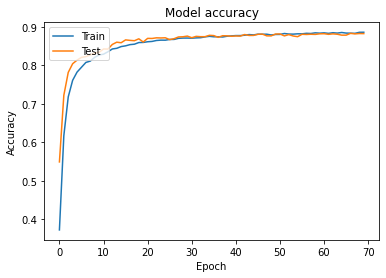

In [46]:
# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

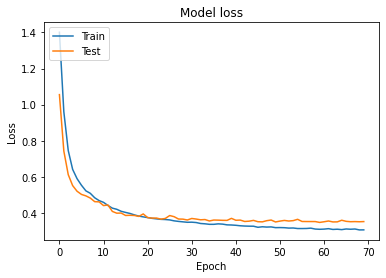

In [47]:
# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [109]:
# predict values
pred = model.predict_proba(test_padded)

In [105]:
pred

array([[1.0421435e-02, 4.3737254e-01, 3.6440670e-02, 5.1468772e-01,
        1.0776214e-03],
       [9.2988215e-02, 2.1969622e-01, 5.3133033e-02, 3.5842463e-01,
        2.7575788e-01],
       [9.8872709e-01, 1.0846229e-02, 1.3740198e-04, 1.0596653e-04,
        1.8323558e-04],
       ...,
       [4.3953749e-04, 9.9952686e-01, 2.3426676e-06, 3.0667899e-05,
        6.0930802e-07],
       [1.2259680e-04, 9.9986291e-01, 8.3824534e-06, 3.4598568e-06,
        2.5793379e-06],
       [9.9772149e-01, 7.3070420e-05, 5.2102905e-04, 4.8813716e-04,
        1.1962368e-03]], dtype=float32)

In [6]:
sub = pd.read_csv('./sample_submission.csv', encoding = 'utf-8')

In [111]:
# submission
sub[['0','1','2','3','4']] = pred
sub.to_csv('mydata_leemodel7.csv', index = False, encoding = 'utf-8')

In [7]:
sub

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


In [8]:
sub2 = pd.read_csv('./mydata_pretrained2.csv', encoding = 'utf-8')

In [2]:
import pandas as pd

In [11]:
sub2['index'] = sub['index']

In [15]:
sub2 = sub2[['index', '0','1','2','3','4']]

In [17]:
sub2.to_csv('mydata_pretrained2.csv', index = False, encoding = 'utf-8')

In [16]:
sub2

,index,0,1,2,3,4
0,0,0.000801,0.249758,0.008452,0.737289,0.003700
1,1,0.376748,0.308439,0.000246,0.005784,0.308784
2,2,0.686431,0.000654,0.007140,0.012858,0.292918
3,3,0.006317,0.002733,0.979572,0.000090,0.011288
4,4,0.602119,0.147803,0.002995,0.198985,0.048097
...,...,...,...,...,...,...
19612,19612,0.002606,0.997278,0.000003,0.000099,0.000014
19613,19613,0.001699,0.013302,0.206371,0.000235,0.778394
19614,19614,0.000837,0.999136,0.000009,0.000013,0.000005
19615,19615,0.100024,0.715463,0.000302,0.180601,0.003610
